

# ArviZ Stancon 2020

Parlarem d'un projecte que creiem que us interessarà molt.

Si estàs llegint la presentació interactiva, prem `espai` per avançar a la següent diapositiva.

# ArviZ i InferenceData


## Agenda
* Els molts passos del flux de treball Bayesià
* On hi encaixa ArviZ
* On hi encaixa InferenceData
* Com s'integra amb la comunitat
* Què no funciona (encara)
* On hi encaixes tu

# Flux de treball Bayesià

Hi ha molts passos i els llenguatges de programació probabilistica (PPLs) només ajuden amb alguns d'ells. ArviZ aspira a ajudar amb la resta.

![Bayesian Workflow](img/Bayesian_workflow_Updated.png)

# Totes les cadenes de MCMC duen al plot_rank
L'elecció de PPL pot dependre de la sintaxi d'aquest o en els algoritmes de mostreig, però les cadenes, mostres, diagnostics, visualització i els objectius del modelatge són bàsicament els mateixos.

![PPLs](img/PPLS.png)

# Una mà d'_arrays_
* Distribució predictiva a priori
* Distribució a posteriori
* Divergències
* Probabilitats logarítmiques per diagnostics
* I encara cal repetir-ho per cada paràmetre considerant differents mides

Els _Datafames_ amb indexació integrada han demostrat ser útils per a l'anàlisi de dades. Les dades Bayesianes són altament dimensionals i comparteixen molts dels reptes.

# Inference Data és un camí
* La seva especificació està disponible en anglès a: https://arviz-devs.github.io/arviz/schema/schema.html
* Cada grup del netCDF emmagatzema una distribució/variable diferent

![idata](https://arviz-devs.github.io/arviz/_images/InferenceDataStructure.png)


# Una ullada a l'InferenceData
* Llegir fitxers netCDF locals
* Generar una instància d'`InferenceData` a partir de PyStan

La integració des de Python amb [CmdStanPy](https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html#From-CmdStanPy), [CmdStan](https://arviz-devs.github.io/arviz/notebooks/InferenceDataCookbook.html#From-CmdStan) i des de Julia amb [CmdStan.jl](https://arviz-devs.github.io/ArviZ.jl/stable/quickstart.html#Plotting-with-CmdStan.jl-outputs-1) també està implementada

## Llegir fitxers netCDF locals

In [2]:
import arviz as az

# Aquí llegim un fitxer .nc previament emmagatzemat online.
# Per llegir un fitxer local: az.from_netcdf("radon.nc")
idata = az.load_arviz_data("radon")
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.ic_pointwise"] = True

## Generar una instància d'`InferenceData` a partir de PyStan


In [3]:
# Inference Data ja és compatible amb les interfícies de Stan (Thanks Ari, Allen and Mitzi!)
import pystan
from scipy import stats
y = stats.norm(10, 1).rvs(1000)
model = """
data {int N; real y[N];} parameters {real mu; real<lower=0> sigma;}
model { mu ~ normal(0, 1); sigma ~ cauchy(0, 1); y ~ normal(mu, sigma);}
"""
stan_model = pystan.StanModel(model_code=model)
fit = stan_model.sampling(data={"y":y, 'N':len(y)})

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7068b6fd3880b0f3a68d15c5c43d21aa NOW.


In [4]:
idata_pystan = az.from_pystan(
    posterior=fit,
    observed_data=["y"],
)
idata_pystan

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

# Les dades estructurades fàciliten el càlcul

## Exploració i diagnosi de la distribució a posteriori

<table style="color:#bbb">
  <tr>
    <th><span style="color:#000">posterior</span></th>
    <th><span style="color:#000">sample stats</span></th>
    <th>log likelihood</th>
    <th>posterior predictive</th>
    <th>observed data</th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

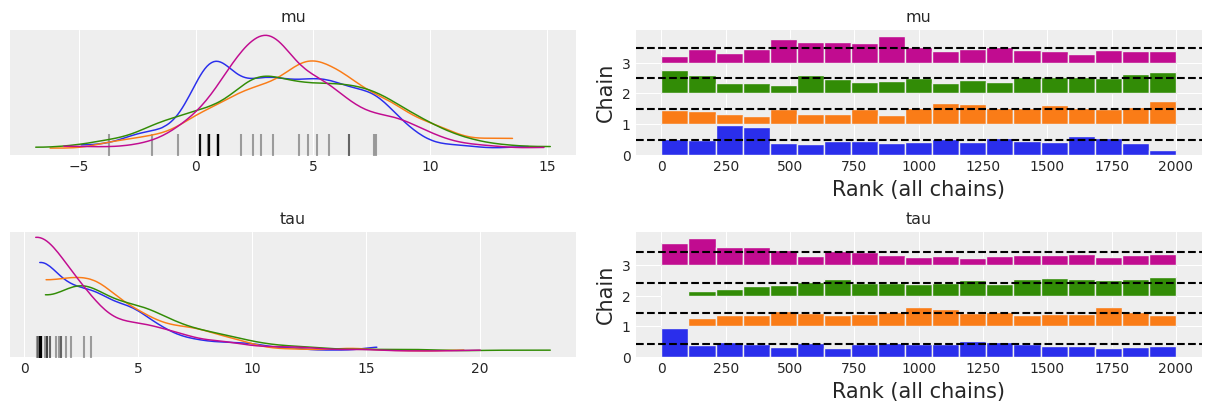

In [5]:
az.plot_trace(az.load_arviz_data("centered_eight"), var_names=["mu", "tau"], kind="rank_bars");

## Validació encreuada deixant-ne un fora (PSIS approximation)
_Leave one out cross validation_ en alglès

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th><span style="color:#000">log likelihood</span></th>
    <th>posterior predictive</th>
    <th>observed data</th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

In [6]:
az.loo(idata)

Computed from 2000 by 919 log-likelihood matrix

         Estimate       SE
elpd_loo -1027.14    28.85
p_loo       26.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      919  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Verificació amb la distribució predictiva a priori
_Prior predictive checks_ en anglès

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th>log likelihood</th>
    <th>posterior predictive</th>
    <th><span style="color:#000">observed data</span></th>
    <th>prior</th>
    <th><span style="color:#000">prior predictive</span></th>
  </tr>
</table>

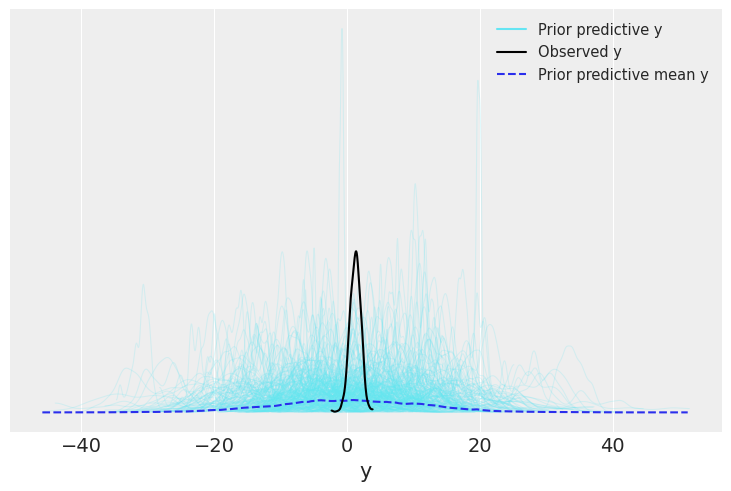

In [7]:
az.plot_ppc(idata, group="prior");

## Transformació integral de probabilitat deixant-ne un fora
_Leave one out probability integral transform_ en anglès

<table style="color:#bbb">
  <tr>
    <th>posterior</th>
    <th>sample stats</th>
    <th><span style="color:#000">log likelihood</span></th>
    <th><span style="color:#000">posterior predictive</span></th>
    <th><span style="color:#000">observed data</span></th>
    <th>prior</th>
    <th>prior predictive</th>
  </tr>
</table>

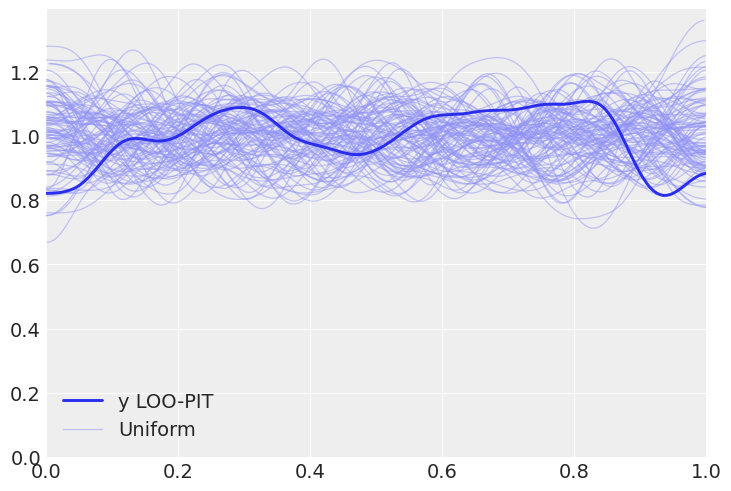

In [8]:
az.plot_loo_pit(idata, y="y");

# Beneficis d'ArviZ i InferenceData
* Estructura de dades compatible amb qualsevol PPL o llenguatge de programació
* Format d'arxius netCDF, portable i persistent
* La facilitat en compartir dades encoratga la reproductibilitat
* Permet als dissenyadors de PPL centrar-se en el PPL i no en l'anàlisi i visualització dels resultats 

# Limitacions
* InferenceData és específic de MCMC
* No permet reproduir completament el flux de treball, només parcialment

# Afegeix InferenceData a la teva llibreria
* InferenceData pot ser només un estructura de dades. 
* No necessites ArviZ ni Python 

![](img/ArviZ.R.png)

# Tota ajuda serà benvinguda!
* Pulir [l'especificació](https://arviz-devs.github.io/arviz/schema/schema.html) InferenceData
* Afegir-hi més plots i diagnostics
* Codi, comentaris i crítiques, compartir publicament els models i gràfics que hagis generat
* Altres millores com ara suport per estructures de dades disperses

## Més informació (enllaços en anglès)

* https://arviz-devs.github.io/arviz/
* https://arviz-devs.github.io/ArviZ.jl/stable/
* https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html
* https://arviz-devs.github.io/arviz/schema/schema.html